In [207]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression



## Read the data

In [208]:
data = pd.read_csv('spotify-2023.csv', encoding='latin-1')
data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [209]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

## 858 lignes pour key et 903 lignes pour in_shazam_charts

In [210]:
df_key = data[data['in_shazam_charts'].notnull()]
data = df_key[df_key['key'].notnull()]
data.loc[:, 'mode'] = [0 if x == 'Minor' else 1 for x in data['mode']]

key_mapping = {
    'A#': 'A',
    'C#': 'C',
    'D#': 'D',
    'F#': 'F',
    'G#': 'G'
}
data.loc[:, 'key_merged'] = data['key'].replace(key_mapping)

/var/folders/wz/q1btcv1x65l01tq61b7l7_rr0000gn/T/ipykernel_51230/2257298326.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'key_merged'] = data['key'].replace(key_mapping)


<Axes: xlabel='key', ylabel='count'>

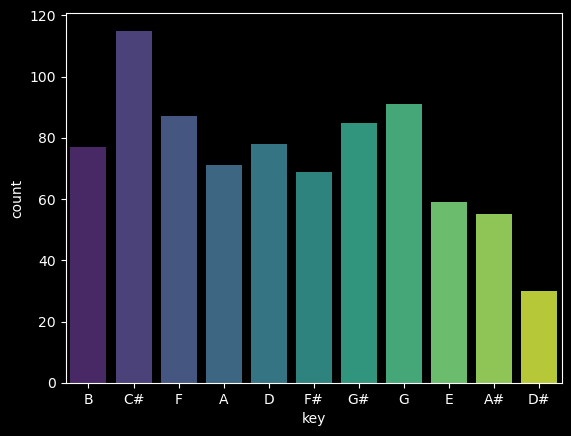

In [211]:
sns.countplot(x='key', data=data, palette='viridis')
#Nombre de musiques totales par clés

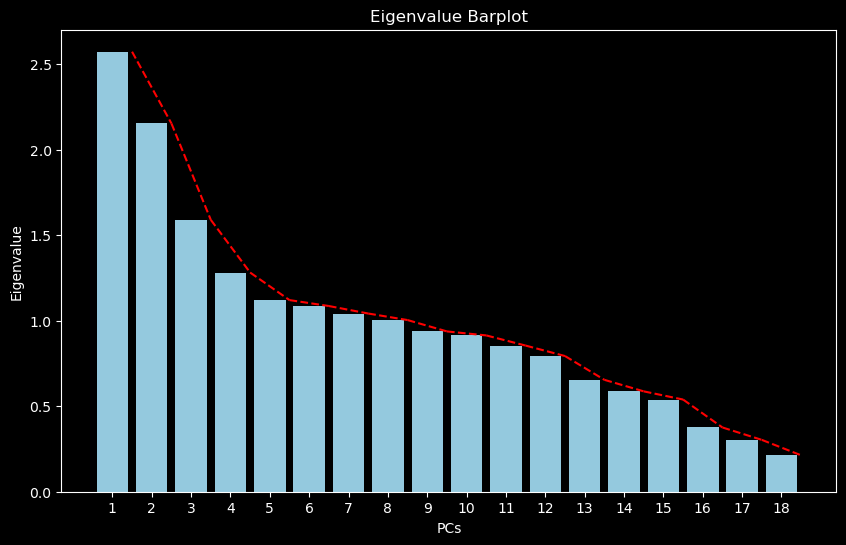

In [212]:
numerical_df = data.select_dtypes(include=np.number)
numerical_df['streams'] = pd.to_numeric(data['streams'], errors = 'coerce')
numerical_df['streams'] = numerical_df['streams'].notna()

# Standardize the data (Z = (X - mean)/sd)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Get the eigenvalues
eigenvalues = pca.explained_variance_

# Plot the eigenvalues
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(eigenvalues) + 1), y=eigenvalues, color='skyblue')
plt.xlabel('PCs')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalue Barplot')
for i in range(len(eigenvalues) - 1):
    plt.plot([i + 0.5, i + 1.5], [eigenvalues[i], eigenvalues[i + 1]], color='red', linestyle='--')
plt.show()

/var/folders/wz/q1btcv1x65l01tq61b7l7_rr0000gn/T/ipykernel_51230/23166301.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bpm_class'] = pd.cut(data['bpm'], bins=[interval[0] for interval in class_intervals] + [float('inf')], labels=class_labels)


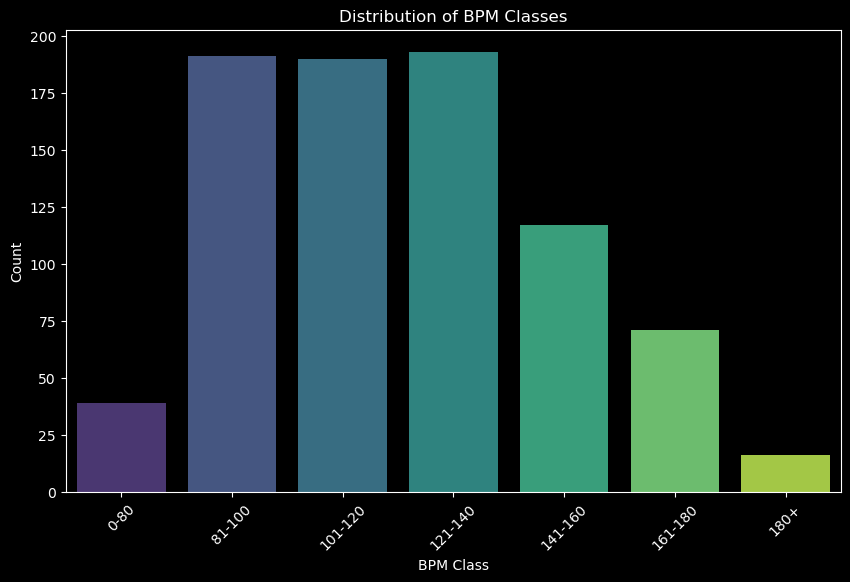

In [213]:
class_intervals = [(0, 80), (81, 100), (101, 120), (121, 140), (141, 160), (161, 180), (181, float('inf'))]
class_labels = ['0-80', '81-100', '101-120', '121-140', '141-160', '161-180', '180+']

# Assign each bpm value to a class
data['bpm_class'] = pd.cut(data['bpm'], bins=[interval[0] for interval in class_intervals] + [float('inf')], labels=class_labels)

# Create the barplot
plt.figure(figsize=(10, 6))
sns.countplot(x='bpm_class', data=data, palette='viridis')
plt.xlabel('BPM Class')
plt.ylabel('Count')
plt.title('Distribution of BPM Classes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#121-140 max count

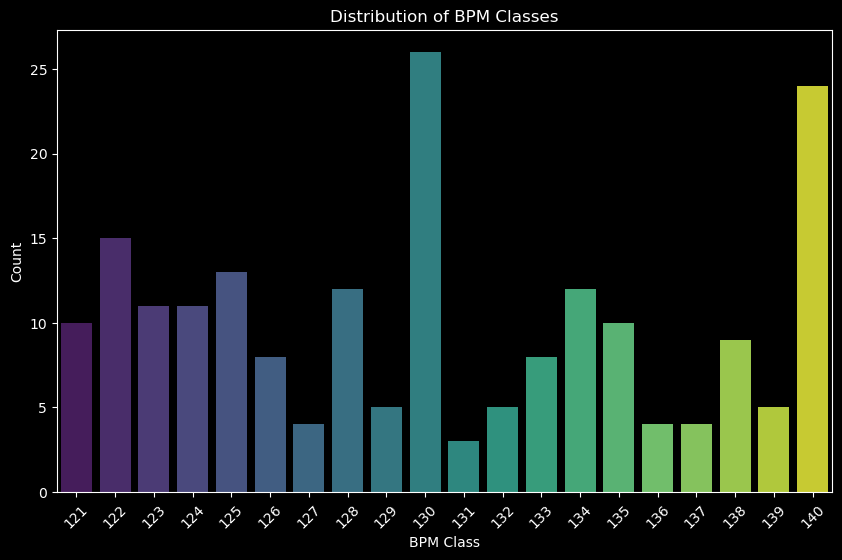

In [214]:
bpm_121_140_df = data[(data['bpm'] >= 121) & (data['bpm'] <= 140)]

# Create the barplot
plt.figure(figsize=(10, 6))
sns.countplot(x='bpm', data=bpm_121_140_df, palette='viridis')
plt.xlabel('BPM Class')
plt.ylabel('Count')
plt.title('Distribution of BPM Classes')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

#130 bpm is the most counted, next is 140

## PCA sur la bpm_class ne donne rien

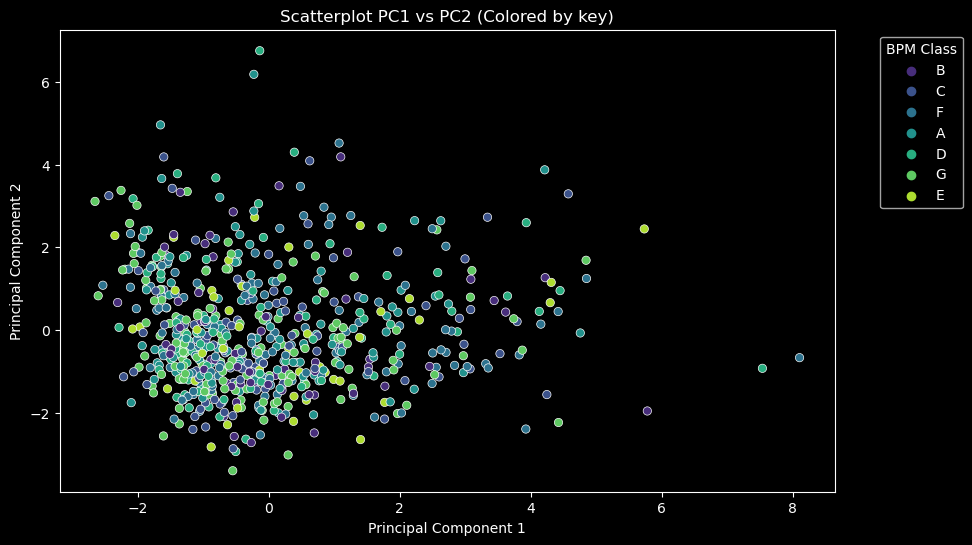

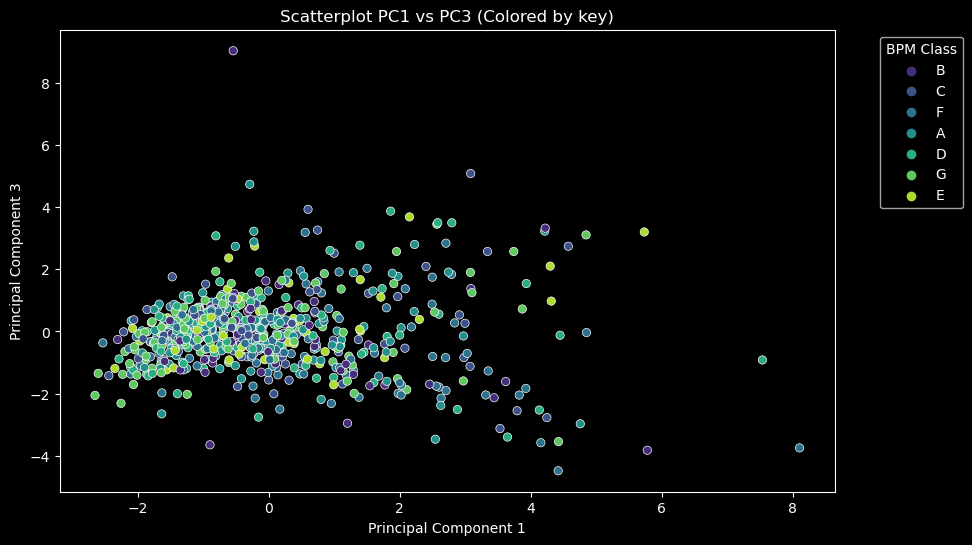

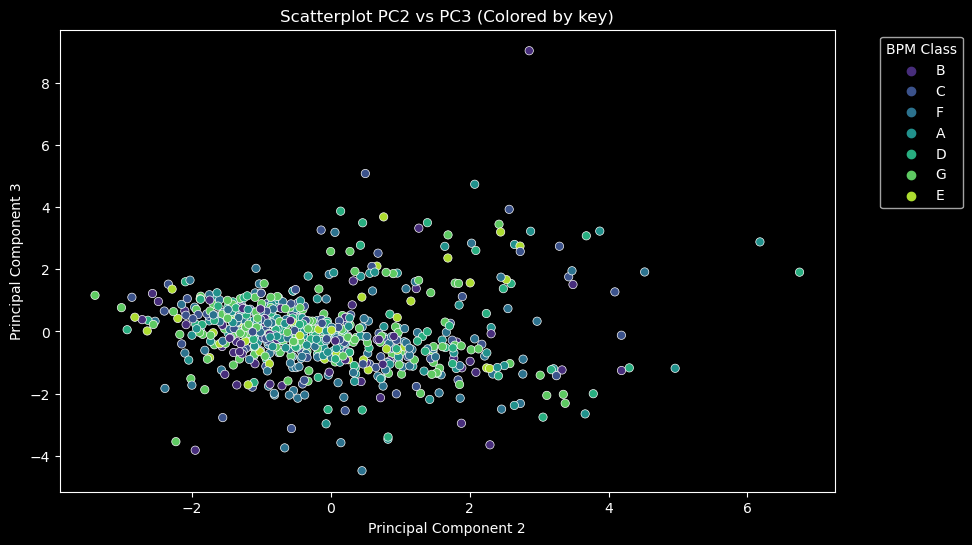

In [215]:
pca_data = pca.transform(scaled_data)
pca_df = pd.DataFrame(data=pca_data[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['bpm_class'] = data['bpm_class']
pca_df['mode'] = data['mode']
pca_df['key'] = data['key_merged']

# Plot the scatterplot of the first two principal components colored by 'bpm_class'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='key', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot PC1 vs PC2 (Colored by key)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='key', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC1 vs PC3 (Colored by key)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='key', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC2 vs PC3 (Colored by key)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

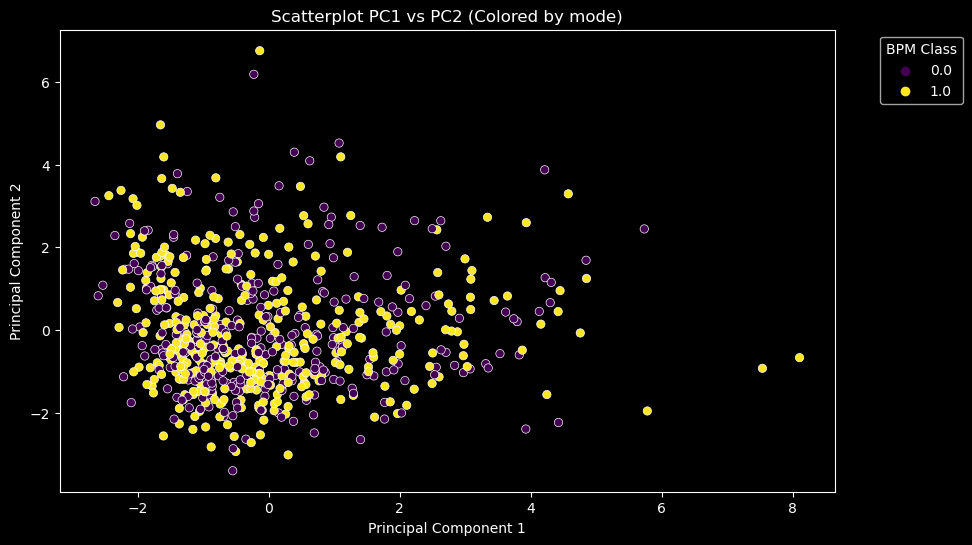

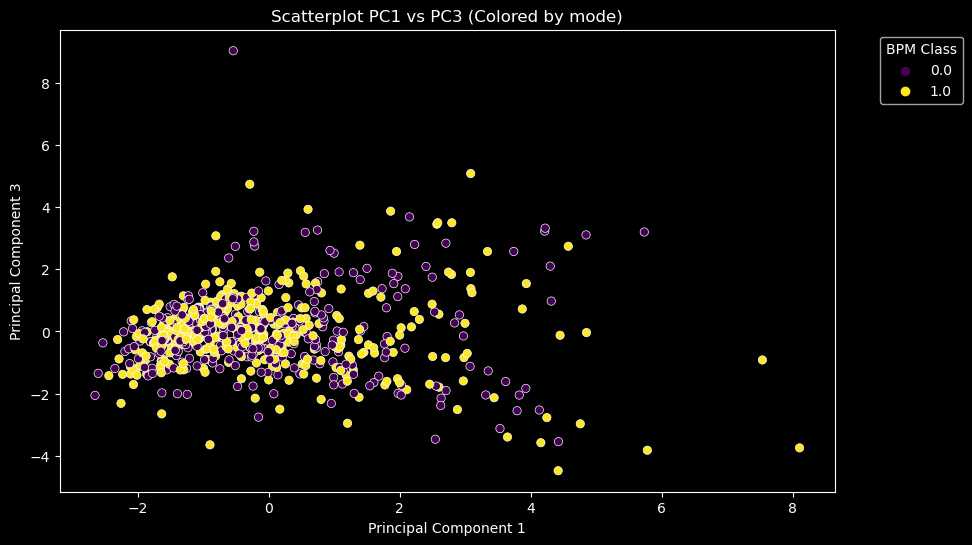

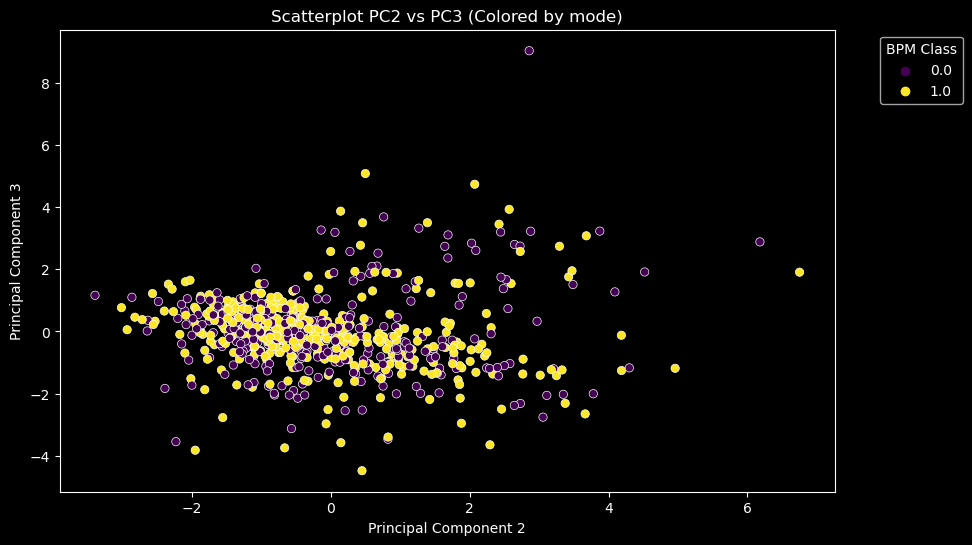

In [216]:
# Plot the scatterplot of the first two principal components colored by 'bpm_class'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='mode', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatterplot PC1 vs PC2 (Colored by mode)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='mode', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC1 vs PC3 (Colored by mode)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='mode', data=pca_df, palette='viridis')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('Scatterplot PC2 vs PC3 (Colored by mode)')
plt.legend(title='BPM Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [217]:
mds = MDS(n_components=3)
mds_data = mds.fit_transform(scaled_data)

# Convert MDS result to DataFrame
mds_df = pd.DataFrame(data=mds_data, columns=['MDS1', 'MDS2', 'MDS3'])
mds_df['bpm_class'] = data['bpm_class']
mds_df['mode'] = data['mode']
mds_df['key'] = data['key_merged']

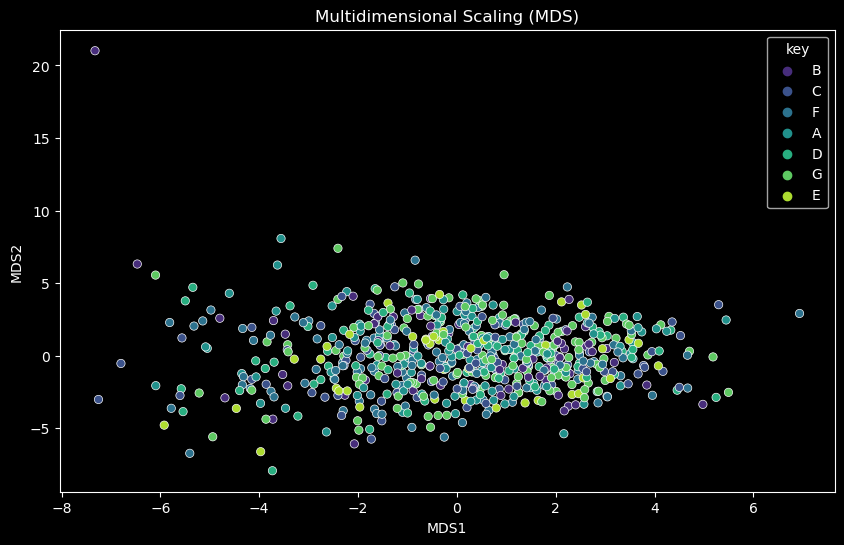

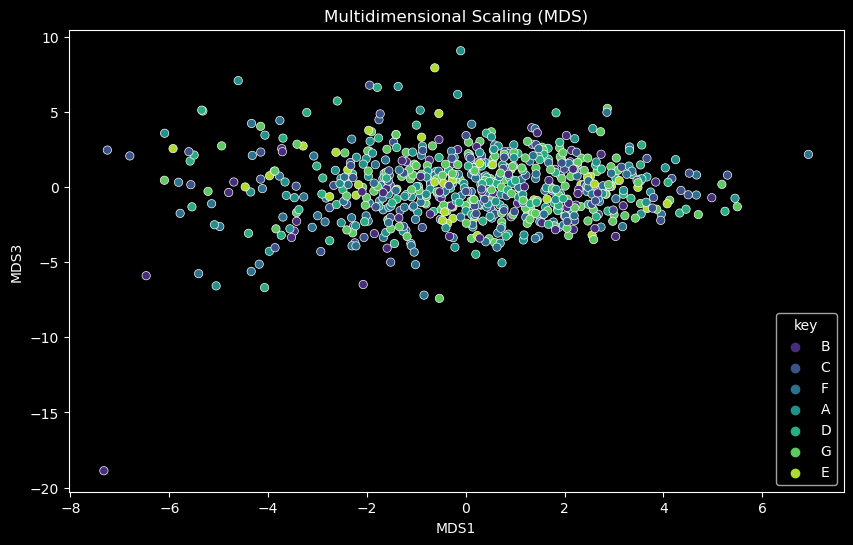

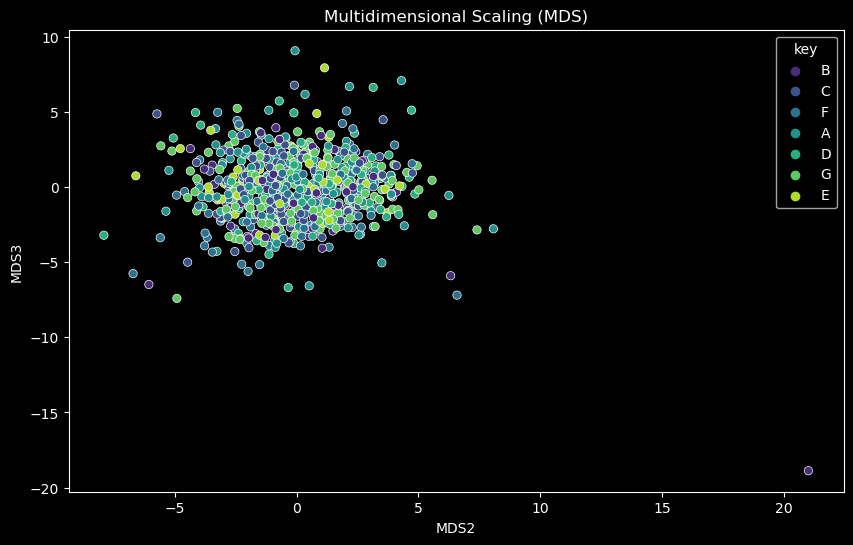

In [218]:
# Plot the scatterplot of the MDS result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS2', hue = 'key', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS3', hue = 'key', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS2', y='MDS3', hue = 'key', data=mds_df, palette='viridis')
plt.xlabel('MDS2')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

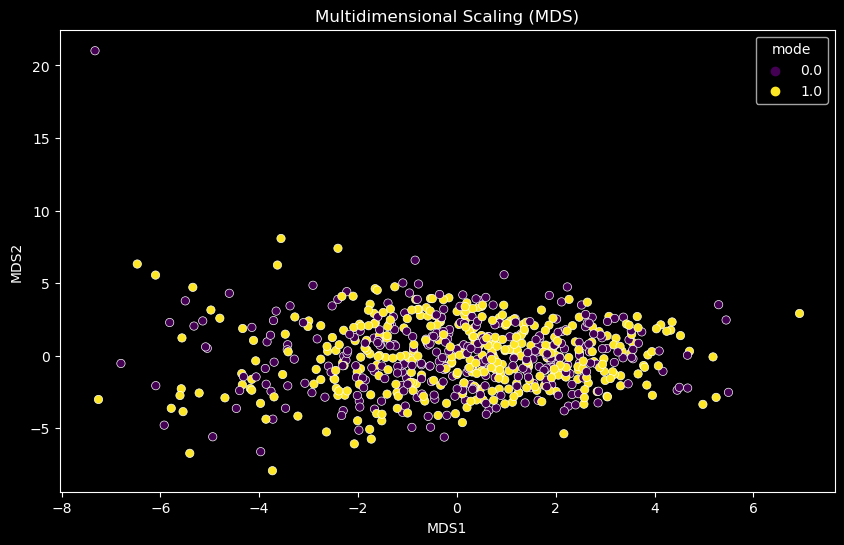

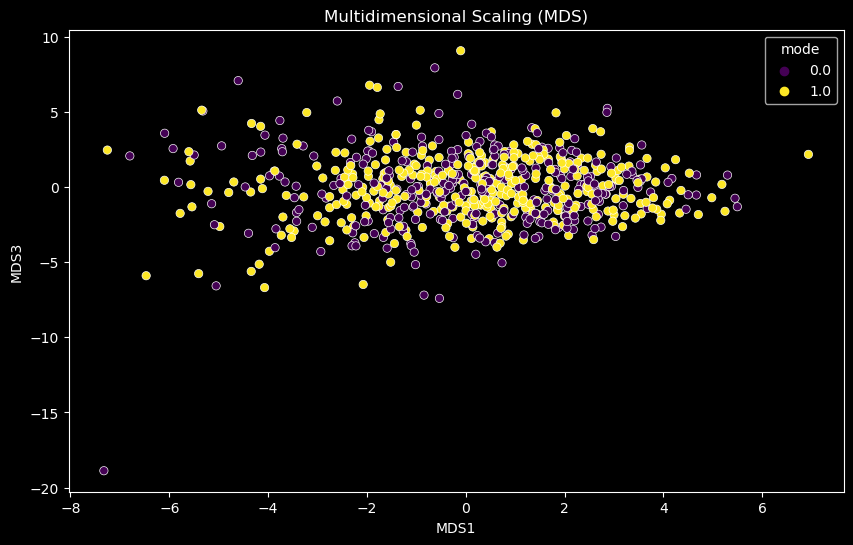

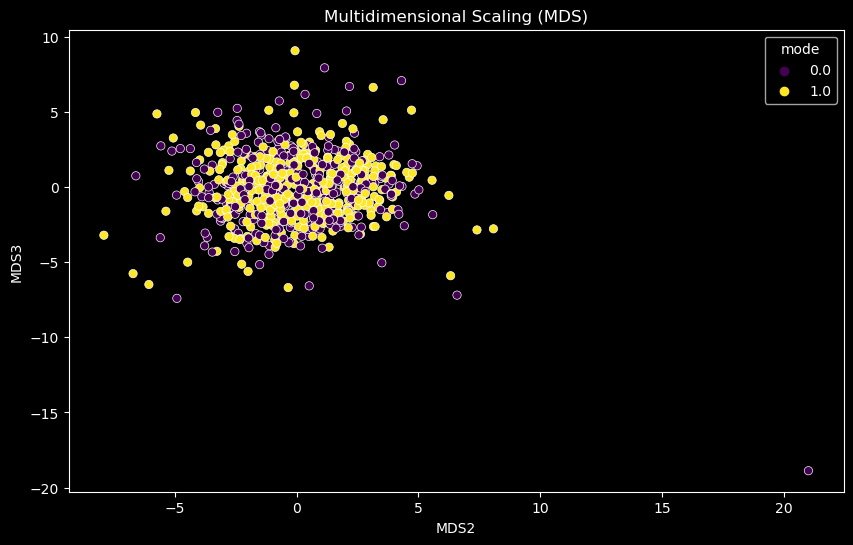

In [219]:
# Plot the scatterplot of the MDS result
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS2', hue = 'mode', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS3', hue = 'mode', data=mds_df, palette='viridis')
plt.xlabel('MDS1')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS2', y='MDS3', hue = 'mode', data=mds_df, palette='viridis')
plt.xlabel('MDS2')
plt.ylabel('MDS3')
plt.title('Multidimensional Scaling (MDS)')
plt.show()

In [220]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=8)
    kmeans.fit(numerical_df)
    wcss.append(kmeans.inertia_)

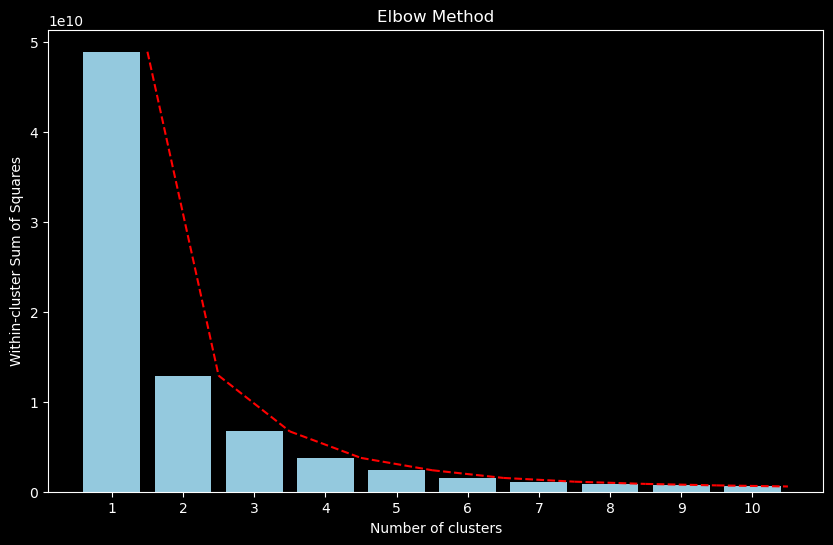

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(1, len(wcss) +1), y=wcss, color="skyblue")
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares')
for i in range(len(wcss) - 1):
    plt.plot([i + 0.5, i + 1.5], [wcss[i], wcss[i + 1]], color='red', linestyle='--')
plt.show()

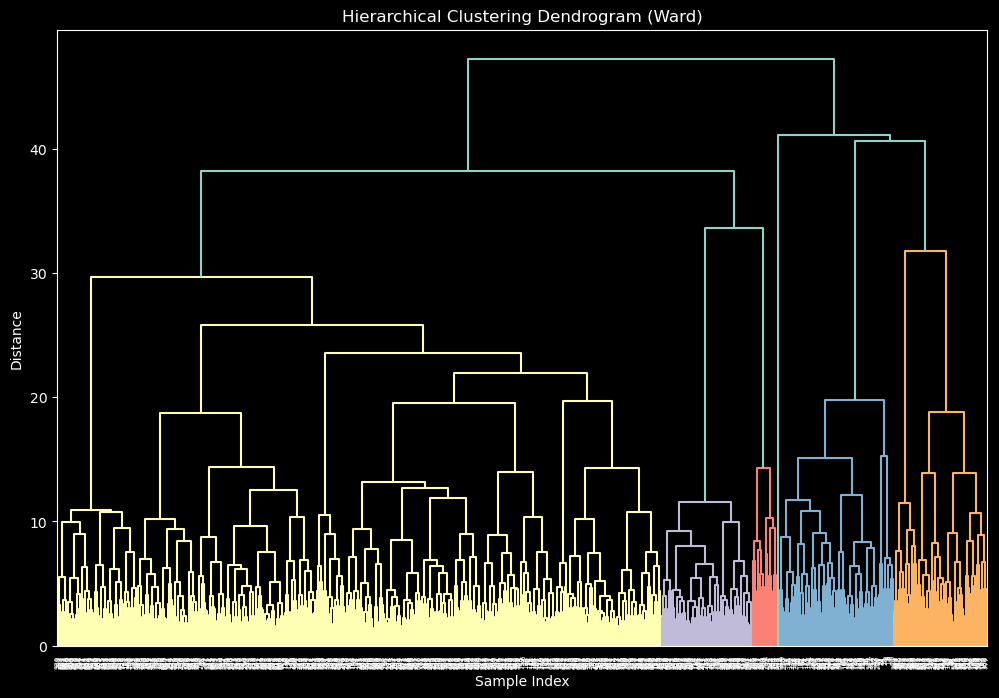

In [ ]:
plt.figure(figsize=(12, 8))
dendrogram(linkage(scaled_data, method = 'ward'))
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
pca = PCA(n_components=3)
pca.fit(numerical_df)

# Get the principal components
components = pca.components_

# Create a DataFrame for better readability
components_df = pd.DataFrame(components, columns=numerical_df.columns, index=['PC1', 'PC2', 'PC3'])

# Get the most important columns for each PC
def get_most_principal_columns(components_df, n_top=3):
    most_principal_columns = {}
    for pc in components_df.index:
        most_principal_columns[pc] = components_df.loc[pc].abs().nlargest(n_top).index.tolist()
    return most_principal_columns

most_principal_columns = get_most_principal_columns(components_df)
print("\nMost Principal Columns:\n", most_principal_columns)


Most Principal Columns:
 {'PC1': ['in_spotify_playlists', 'in_apple_playlists', 'in_apple_charts'], 'PC2': ['in_apple_playlists', 'in_apple_charts', 'in_spotify_charts'], 'PC3': ['in_apple_charts', 'in_apple_playlists', 'in_spotify_charts']}


In [ ]:
kmeans = KMeans(n_clusters=3, random_state=8)
kmeans.fit(numerical_df)

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Create a DataFrame for better readability
cluster_centers_df = pd.DataFrame(cluster_centers, columns=numerical_df.columns)

# Get the most important features for each cluster
def get_most_principal_features(cluster_centers_df, n_top=3):
    most_principal_features = {}
    for cluster in cluster_centers_df.index:
        most_principal_features[f'Cluster {cluster}'] = cluster_centers_df.loc[cluster].nlargest(n_top).index.tolist()
    return most_principal_features

most_principal_features = get_most_principal_features(cluster_centers_df)
print("\nMost Principal Features:\n", most_principal_features)


Most Principal Features:
 {'Cluster 0': ['in_spotify_playlists', 'released_year', 'bpm'], 'Cluster 1': ['in_spotify_playlists', 'released_year', 'in_apple_playlists'], 'Cluster 2': ['in_spotify_playlists', 'released_year', 'in_apple_playlists']}


## 2 clusters

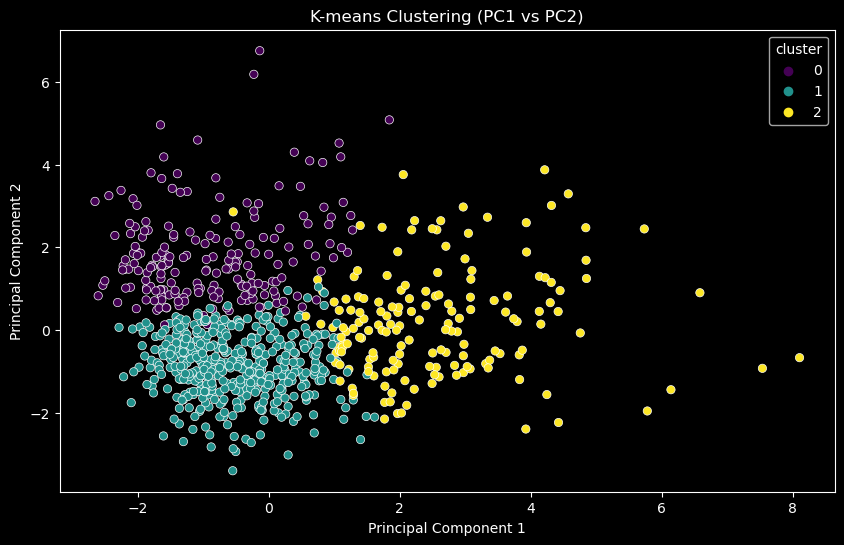

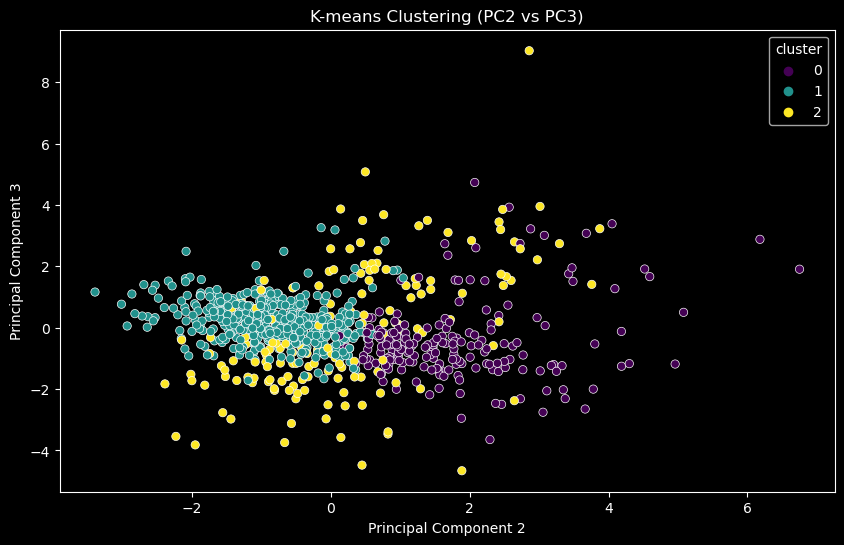

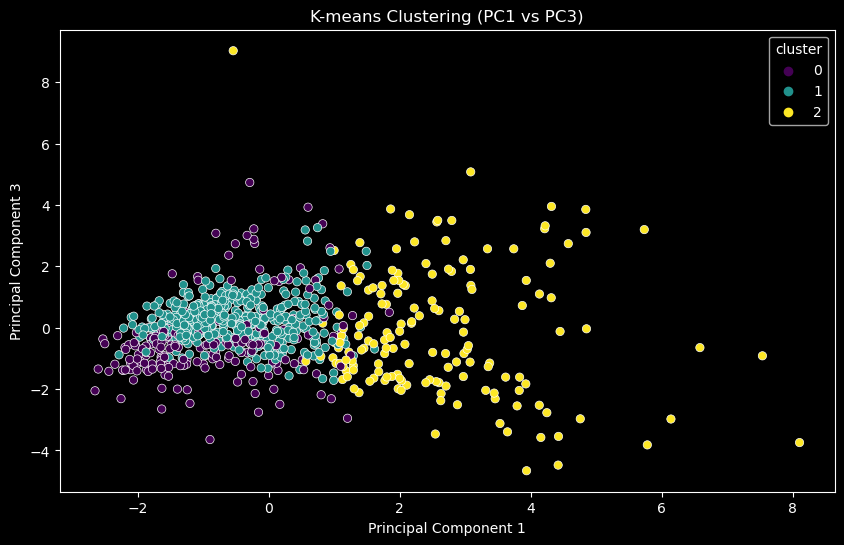

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_data)

# Add cluster labels to the DataFrame
pca_df['cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC2', y='PC3', hue='cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering (PC2 vs PC3)')
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC3', hue='cluster', data=pca_df, palette='viridis')
plt.title('K-means Clustering (PC1 vs PC3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 3')
plt.show()

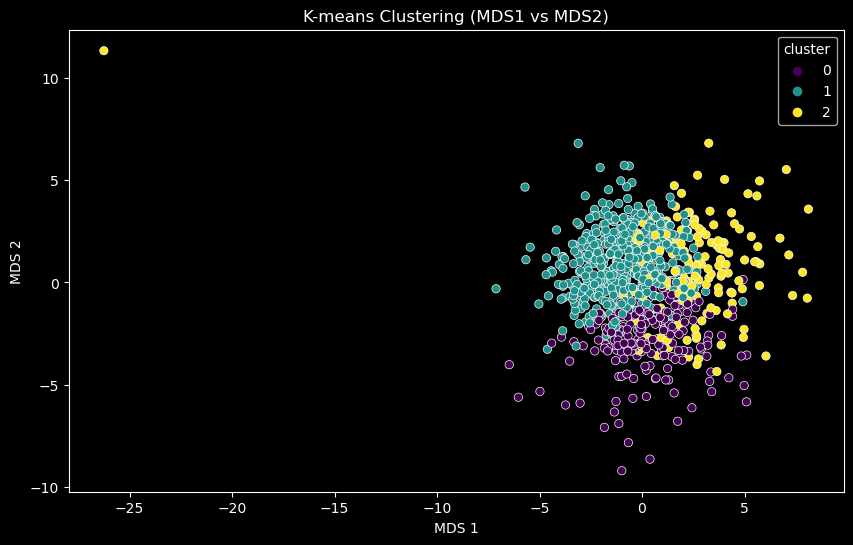

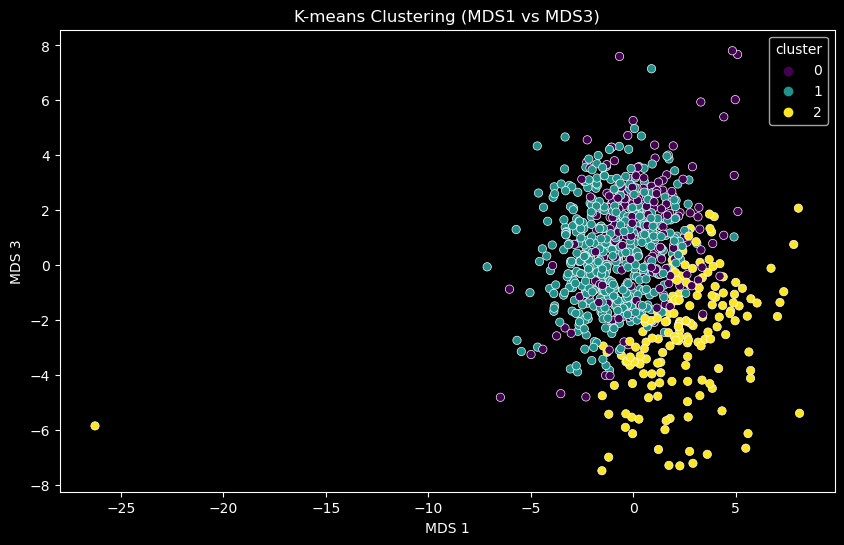

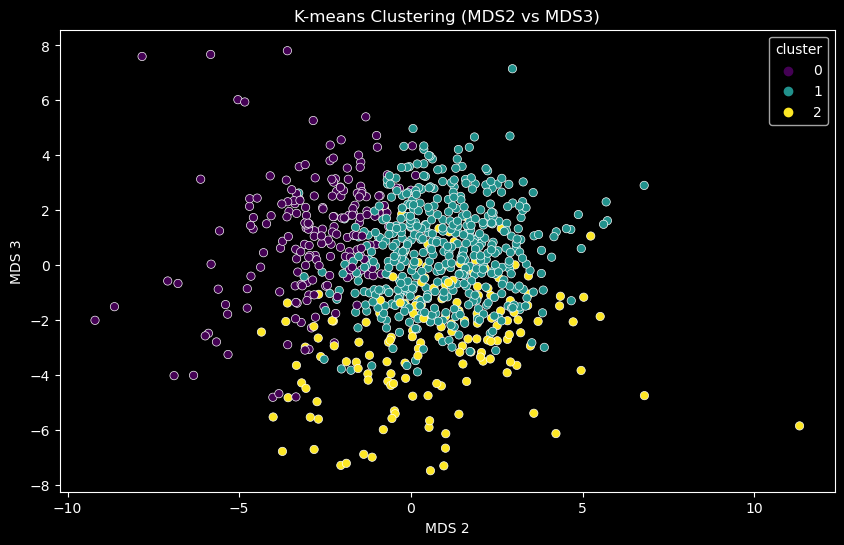

In [ ]:
# Add cluster labels to the DataFrame
mds_df['cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS2', hue='cluster', data=mds_df, palette='viridis')
plt.title('K-means Clustering (MDS1 vs MDS2)')
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS1', y='MDS3', hue='cluster', data=mds_df, palette='viridis')
plt.title('K-means Clustering (MDS1 vs MDS3)')
plt.xlabel('MDS 1')
plt.ylabel('MDS 3')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='MDS2', y='MDS3', hue='cluster', data=mds_df, palette='viridis')
plt.title('K-means Clustering (MDS2 vs MDS3)')
plt.xlabel('MDS 2')
plt.ylabel('MDS 3')
plt.show()

# Finding a predictive variable

In [ ]:
# Create a new DataFrame with relevant columns
relevant_columns = ['streams', 'bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_deezer_playlists', 'in_shazam_charts']
df_relevant = data[relevant_columns].copy()
# Convert 'streams' and other relevant columns to numeric
df_relevant['streams'] = pd.to_numeric(df_relevant['streams'], errors='coerce')
df_relevant['in_deezer_playlists'] = pd.to_numeric(df_relevant['in_deezer_playlists'], errors='coerce')
df_relevant['in_shazam_charts'] = pd.to_numeric(df_relevant['in_shazam_charts'], errors='coerce')


# Drop rows with missing values in relevant columns
df_relevant = df_relevant.dropna()
# Define the independent variables (X) and the dependent variable (y)
X = df_relevant[['bpm', 'danceability_%', 'valence_%', 'energy_%', 'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%', 'in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_deezer_playlists', 'in_shazam_charts']]
y = df_relevant['streams']

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                streams   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     113.8
Date:                Tue, 04 Jun 2024   Prob (F-statistic):          5.54e-166
Time:                        19:45:00   Log-Likelihood:                -15393.
No. Observations:                 748   AIC:                         3.081e+04
Df Residuals:                     734   BIC:                         3.088e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.069e+08 

In [ ]:
def calculate_and_plot_correlation(df, col1, col2, plot=True):
    
    df.loc[:, col1] = pd.to_numeric(df[col1], errors='coerce')
    df.loc[:, col2] = pd.to_numeric(df[col2], errors='coerce')

    # Drop rows with missing values in the specified columns
    df_clean = df.dropna(subset=[col1, col2])
    
    # Calculate the correlation
    correlation = df_clean[col1].corr(df_clean[col2])
    
    # Print the correlation coefficient
    print(f"Correlation between {col1} and {col2}: {correlation}")
    
    # Optionally plot the data
    if plot:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df_clean, x=col1, y=col2)
        plt.xlabel(col1)
        plt.ylabel(col2)
        plt.title(f'Correlation between {col1} and {col2}')
        plt.show()
    
    return correlation


In [ ]:

data = data.dropna()
data.loc[:, 'streams'] = pd.to_numeric(data['streams'], errors= 'coerce')
data.loc[:, 'in_deezer_playlists'] = pd.to_numeric(data['in_deezer_playlists'], errors= 'coerce')
data.loc[:, 'in_shazam_charts'] = pd.to_numeric(data['in_shazam_charts'], errors= 'coerce')
data.loc[:, 'mode'] = [0 if x == 'Minor' else 1 for x in data['mode']]
data['mode'] = data['mode'].dropna()
data['mode'] = data['mode'].astype(int)
data['streams'] = data['streams'].astype(int)
data['in_deezer_playlists'] =data['in_deezer_playlists'].astype(int)
data['in_shazam_charts'] = data['in_shazam_charts'].astype(int)

ValueError: cannot convert float NaN to integer

In [ ]:
print(data.dtypes)

track_name                object
artist(s)_name            object
artist_count               int64
released_year              int64
released_month             int64
released_day               int64
in_spotify_playlists       int64
in_spotify_charts          int64
streams                    int64
in_apple_playlists         int64
in_apple_charts            int64
in_deezer_playlists        int64
in_deezer_charts           int64
in_shazam_charts           int64
bpm                        int64
key                       object
mode                       int64
danceability_%             int64
valence_%                  int64
energy_%                   int64
acousticness_%             int64
instrumentalness_%         int64
liveness_%                 int64
speechiness_%              int64
key_merged               float64
bpm_class               category
dtype: object


Correlation between streams and mode: nan


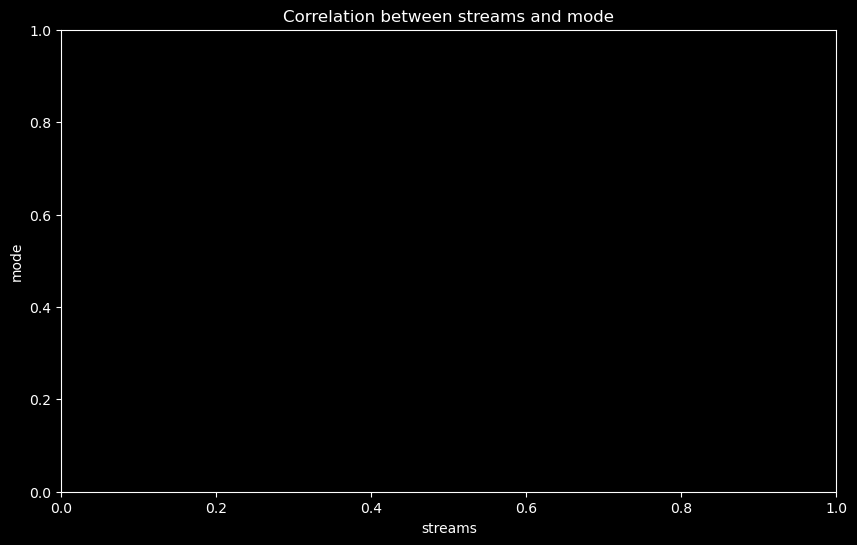

In [ ]:
# Example usage:
correlation = calculate_and_plot_correlation(data, 'streams', 'mode', True)

In [ ]:
def compute_correlation_matrix(df):
    # Select only integer columns
    int_df = df.select_dtypes(include='int64')
    
    # Compute the correlation matrix
    correlation_matrix = int_df.corr()
    
    return correlation_matrix
correlation_matrix = compute_correlation_matrix(data)
print(correlation_matrix)

                      artist_count  released_year  released_month  \
artist_count                   NaN            NaN             NaN   
released_year                  NaN            NaN             NaN   
released_month                 NaN            NaN             NaN   
released_day                   NaN            NaN             NaN   
in_spotify_playlists           NaN            NaN             NaN   
in_spotify_charts              NaN            NaN             NaN   
streams                        NaN            NaN             NaN   
in_apple_playlists             NaN            NaN             NaN   
in_apple_charts                NaN            NaN             NaN   
in_deezer_playlists            NaN            NaN             NaN   
in_deezer_charts               NaN            NaN             NaN   
in_shazam_charts               NaN            NaN             NaN   
bpm                            NaN            NaN             NaN   
mode                           NaN

## Correlation between Variables ##

1. (streams, in_spotify_playlists): **0.76**
2. (in_spotify_playlists, in_apple_playlists): **0.70**
3. (in_spotify_playlists, in_deezer_playlists): **0.79**
4. (streams, in_deezer_playlists): **0.71**
5. (streams, in_apple_playlists): **0.67**
